
# MPA-MLF, Miniproject
### *Kassen Boyaubay*

### 0. Mount Files

In [1]:
!wget https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/x_train.csv
!wget https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/y_train.csv
!wget https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/x_test.csv
!wget https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/sample_file.csv

--2023-03-17 10:34:42--  https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/x_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2213327 (2.1M) [text/plain]
Saving to: ‘x_train.csv’

x_train.csv         100%[===================>]   2.11M  --.-KB/s    in 0.009s  

2023-03-17 10:34:42 (243 MB/s) - ‘x_train.csv’ saved [2213327/2213327]

--2023-03-17 10:34:42--  https://raw.githubusercontent.com/KassenBoyaubay/MPA-MLF-Exercises/main/Miniproject/y_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Import libraries

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD, Adam
# from keras.datasets import cifar10
from keras.utils import to_categorical
# from keras.callbacks import EarlyStopping
# from keras import regularizers
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.svm import LinearSVC
from numpy import argmax
# import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset

In [4]:
x_test_path = 'x_test.csv' 
x_test = pd.read_csv(x_test_path)

x_train_path = 'x_train.csv' 
x_train = pd.read_csv(x_train_path)

y_train_path = 'y_train.csv' 
y_train = pd.read_csv(y_train_path)

sample_file_path = 'sample_file.csv' 
sample_file = pd.read_csv(sample_file_path)

### 2. Data Examination

In [5]:
x_train.iloc[0:4]

,Unnamed: 0,cfo_demod,gain_imb,iq_imb,or_off,quadr_err,m_power,ph_err,mag_err,evm,Tosc,Tmix
0,0,592.234802,0.048079,-35.082729,-28.560846,1.993170,-0.499721,1.107926,1.507550,2.423943,39.9,47.6
1,1,-103.302032,-0.019917,-29.946953,-35.798664,-3.642311,-0.928193,1.236059,2.741568,3.458056,14.8,23.1
2,2,-582.331299,0.036379,-32.096672,-31.905628,2.835839,-1.272485,1.282163,2.140096,3.013522,42.5,48.6
3,3,-630.611267,0.063928,-38.216297,-30.084171,1.346316,-0.596438,1.154848,1.093465,2.254514,26.1,35.4


In [6]:
y_train.iloc[0:4]

,id,target
0,0,5
1,1,1
2,2,6
3,3,3


In [7]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('\nx_train columns:', x_train.columns)
for x_train_dtype in x_train.columns[1:]:
  print(f'{x_train_dtype} dtype:', x_train[x_train_dtype].dtype)

print('\ny_train unique values:', y_train['target'].unique())

print('\nThis is a classification task')
print('data samples:', len(x_train) + len(x_test))
print('features (not yet preprocessed):', len(x_train.columns))
print('labels:', len(y_train['target'].unique()))
print('is there any missing (NaN/null) values in x_train:', x_train.isnull().values.any() or x_train.isna().values.any())

x_train shape: (15360, 12)
x_test shape: (3840, 12)
y_train shape: (15360, 2)

x_train columns: Index(['Unnamed: 0', 'cfo_demod', 'gain_imb', 'iq_imb', 'or_off', 'quadr_err',
       'm_power', 'ph_err', 'mag_err', 'evm', 'Tosc', 'Tmix'],
      dtype='object')
cfo_demod dtype: float64
gain_imb dtype: float64
iq_imb dtype: float64
or_off dtype: float64
quadr_err dtype: float64
m_power dtype: float64
ph_err dtype: float64
mag_err dtype: float64
evm dtype: float64
Tosc dtype: float64
Tmix dtype: float64

y_train unique values: [5 1 6 3 2 7 8 4]

This is a classification task
data samples: 19200
features (not yet preprocessed): 12
labels: 8
is there any missing (NaN/null) values in x_train: False


### 3. Data Prepocessing

#### 3.1 Removal of unused features/columns

In [43]:
x_train_prepr_features = x_train.drop(columns=['Tosc', 'Tmix', 'm_power', 'Unnamed: 0'], inplace=False)
x_test_prepr_features = x_test.drop(columns=['Tosc', 'Tmix', 'm_power', 'Unnamed: 0'], inplace=False)
y_train_prepr_drop = y_train.drop(columns='id', inplace=False)
y_train_prepr = y_train_prepr_drop.values.flatten()

In [9]:
print('overall number of features after preprocessing:', len(x_train_prepr_features.columns))

overall number of features after preprocessing: 8


In [25]:
features_num = len(x_train_prepr_features.columns)
labels_num = len(y_train['target'].unique())

#### 3.2 Normalization of data

min max scaler vs. standard scaler

In [10]:
Xscaler1 = StandardScaler()
Xscaler2 = MinMaxScaler()
Xstdscaler=Xscaler1.fit_transform(x_train_prepr_features)
Xminmax=Xscaler2.fit_transform(x_train_prepr_features)

<Figure size 432x288 with 0 Axes>

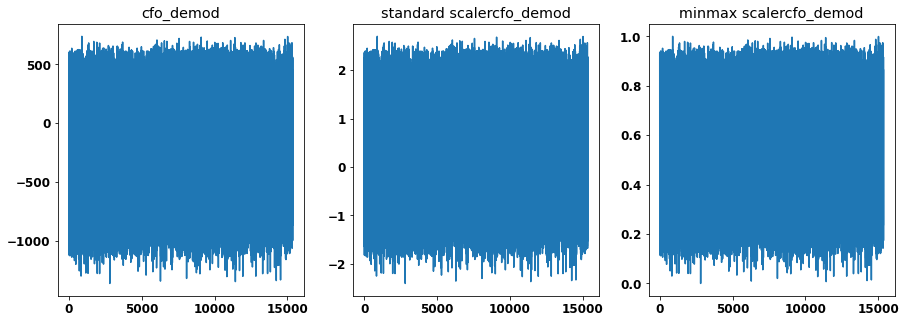

<Figure size 432x288 with 0 Axes>

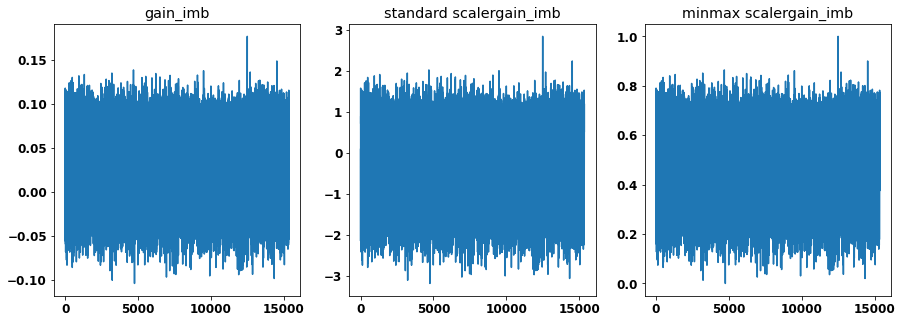

<Figure size 432x288 with 0 Axes>

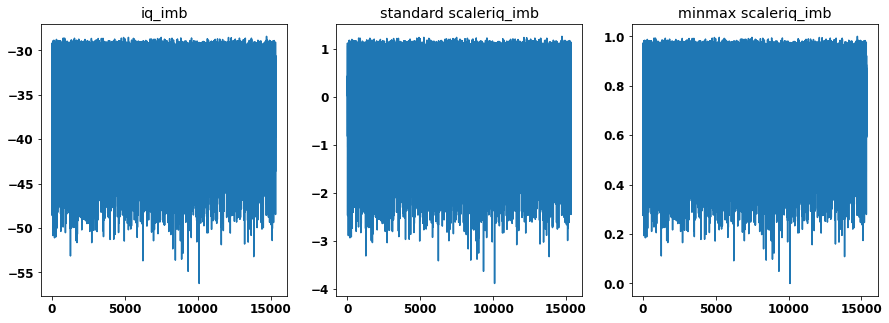

<Figure size 432x288 with 0 Axes>

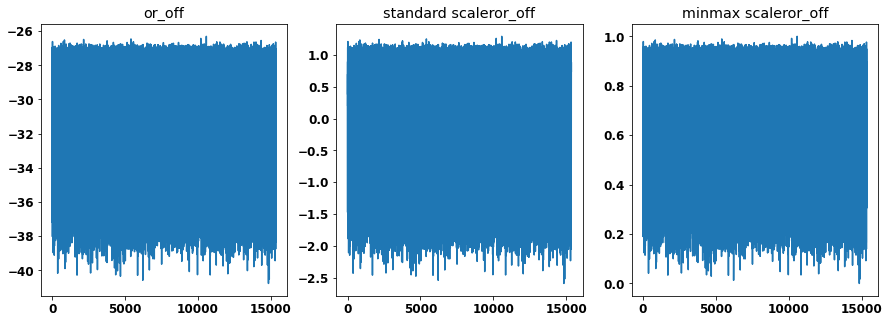

<Figure size 432x288 with 0 Axes>

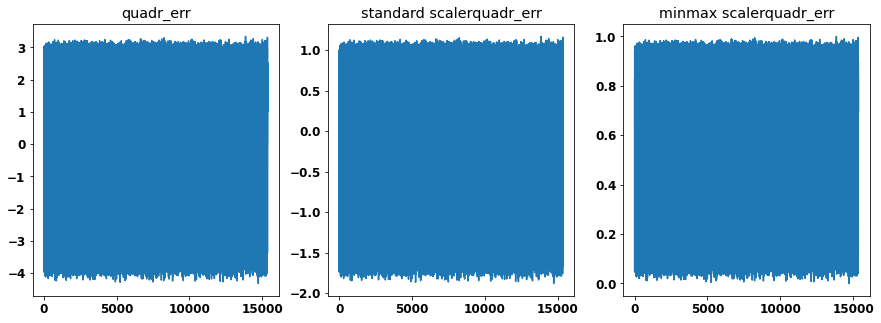

<Figure size 432x288 with 0 Axes>

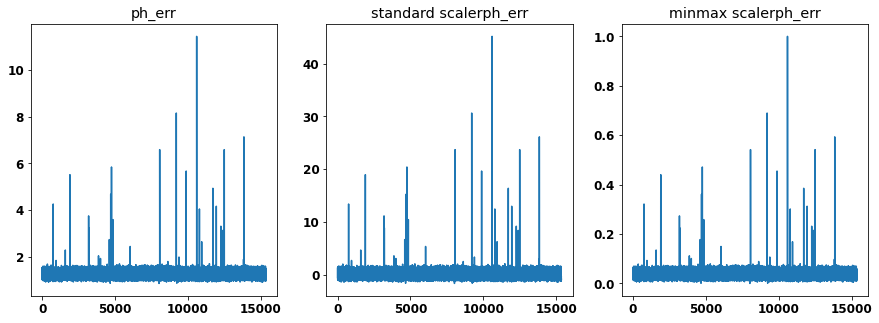

<Figure size 432x288 with 0 Axes>

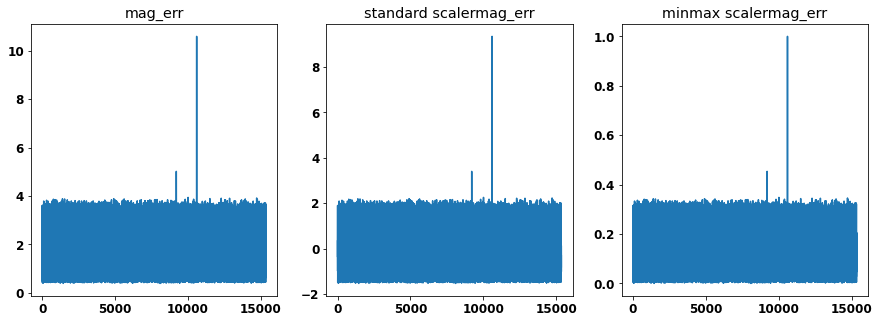

<Figure size 432x288 with 0 Axes>

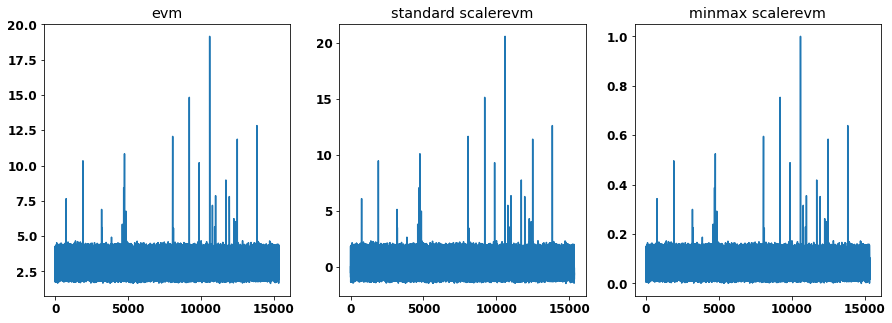

In [11]:
for col, x_train_dtype in enumerate(x_train_prepr_features.columns):
  plt.figure()
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
  axes[0].plot(x_train_prepr_features[x_train_dtype])
  axes[0].set_title(x_train_dtype)
  axes[1].plot(Xstdscaler[:,col])
  axes[1].set_title('standard scaler' + x_train_dtype)
  axes[2].plot(Xminmax[:,col])
  axes[2].set_title('minmax scaler' + x_train_dtype)
  # add labels

Since there are some feature datasets that possess extreme values (outliners), the standard scaler seems more suitable

We need to normalize all values inside x_train and x_test

In [12]:
x_train_prepr_norm=Xscaler1.fit_transform(x_train_prepr_features)
x_test_prepr_norm=Xscaler1.fit_transform(x_test_prepr_features)

#### 3.3 PCA

In [13]:
pca = decomposition.PCA()
x_train_prepr_pca = pca.fit_transform(x_train_prepr_norm)
x_test_prepr_pca = pca.fit_transform(x_test_prepr_norm)

### 4. SVM

#### 4.1 Creating the model

In [28]:
SVMmodel=LinearSVC()
SVMmodel.fit(x_train_prepr_pca, y_train_prepr)
SVMmodel.get_params()
SVMmodel.score(x_train_prepr_pca, y_train_prepr)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9983723958333334

#### 4.2 Model prediction

In [15]:
y_svm_pred = SVMmodel.predict(x_test_prepr_pca)

#### 4.3 Postprocessing prediction

In [16]:
y_svm_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_svm_pred)), 'target': y_svm_pred})

#### 4.4 Export to CSV

In [17]:
y_svm_pred_postpr.to_csv('y_pred_svm.csv', index=False)

### 5. MLP

#### 5.1 Model architecture

In [99]:
model = Sequential()
model.add(Dense(features_num, input_dim=features_num, activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(labels_num, activation='softmax'))

In [100]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


#### 5.2 Compile the model

In [101]:
optimizer = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### 5.3 Train the model

One-hot encoding of labels is needed

In [65]:
y_train_encoded = to_categorical(y_train_prepr_drop-1, num_classes=labels_num)

In [102]:
history = model.fit(x_train_prepr_pca, y_train_encoded, epochs=20, batch_size=100, verbose=2, validation_split=0.2)

Epoch 1/20
123/123 - 1s - loss: 2.1005 - accuracy: 0.1274 - val_loss: 2.0389 - val_accuracy: 0.1283 - 831ms/epoch - 7ms/step
Epoch 2/20
123/123 - 0s - loss: 1.9885 - accuracy: 0.1545 - val_loss: 1.9485 - val_accuracy: 0.2653 - 335ms/epoch - 3ms/step
Epoch 3/20
123/123 - 0s - loss: 1.9081 - accuracy: 0.2851 - val_loss: 1.8746 - val_accuracy: 0.3057 - 340ms/epoch - 3ms/step
Epoch 4/20
123/123 - 0s - loss: 1.8363 - accuracy: 0.3454 - val_loss: 1.8043 - val_accuracy: 0.3965 - 336ms/epoch - 3ms/step
Epoch 5/20
123/123 - 0s - loss: 1.7667 - accuracy: 0.4292 - val_loss: 1.7358 - val_accuracy: 0.4548 - 332ms/epoch - 3ms/step
Epoch 6/20
123/123 - 0s - loss: 1.6989 - accuracy: 0.4670 - val_loss: 1.6699 - val_accuracy: 0.4756 - 345ms/epoch - 3ms/step
Epoch 7/20
123/123 - 0s - loss: 1.6348 - accuracy: 0.4811 - val_loss: 1.6084 - val_accuracy: 0.4847 - 361ms/epoch - 3ms/step
Epoch 8/20
123/123 - 0s - loss: 1.5753 - accuracy: 0.4984 - val_loss: 1.5519 - val_accuracy: 0.5104 - 338ms/epoch - 3ms/step


In [103]:
score = model.evaluate(x_train_prepr_pca, y_train_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 1.070330023765564
Test accuracy: 75.54687261581421 %


Text(0, 0.5, 'loss')

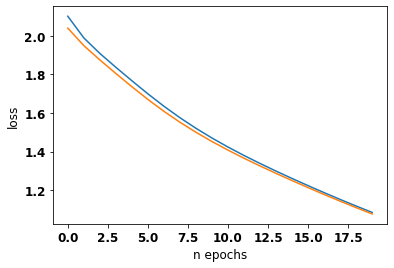

In [104]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

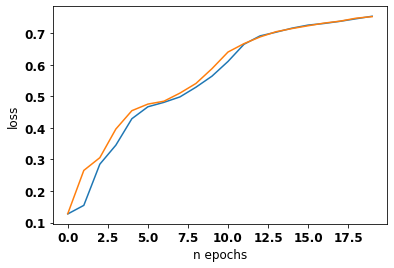

In [105]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

#### 5.4 Model prediction

In [112]:
y_pred_enc = model.predict(x_test_prepr_pca)

120/120 [==============================] - 0s 1ms/step


#### 5.5 Postprocessing prediction

In [113]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [114]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

#### 5.6 Export to CSV

In [115]:
y_pred_postpr.to_csv('y_pred_mlp.csv', index=False)